In [12]:
from fastchat.llm_judge.common import load_questions, load_model_answers

#medusa_path = 'llm_judge/data/mt_bench/model_answer/medusa_vicuna-7b-v1.3_medusa_5-temperature-0.0-posterior_threshold-0.09-posterior_alpha-0.3-top_p-0.8-sampling-typical-fast-False.jsonl'
#medusa_path = 'llm_judge/data/mt_bench/model_answer/official_medusa_vicuna-7b-v1.3_medusa_5-temperature-0.0-posterior_threshold-0.09-posterior_alpha-0.3-top_p-0.8-sampling-typical-fast-False.jsonl'
medusa_path = 'data/mt_bench/model_answer/vicuna-7b-v1.3-level-5-win-15-guess-15-f0-pp0.jsonl'
base_path = 'data/mt_bench/model_answer/baseline-vicuna-7b-v1.3.jsonl'
ques_path = 'mtbench.jsonl'

In [13]:
medusa_ans = load_questions(medusa_path, None, None)
base_ans = load_questions(base_path, None, None)
ques = load_questions(ques_path, None, None)

In [14]:
def gather_attr(ans: list, attr: str):
    '''
    Gather attr from a list of json object

    Args:
    - ans: answer list
    - attr: attributes of json object, including idxs, new_tokens, wall_time

    Return:
    - a list of target attributes
    '''
    attrs = []
    for item in ans:
        attrs.append(sum(item['choices'][0][attr]))
    return attrs

In [15]:
bench_dict = {'id': [item['question_id'] for item in ques], 'category': [item['category'] for item in ques]}
colomn = ['idxs', 'new_tokens', 'wall_time']
for key in colomn:
    bench_dict['medusa_'+key] = gather_attr(medusa_ans, key)
for key in colomn:
    bench_dict['base_'+key] = gather_attr(base_ans, key)

In [16]:
import pandas as pd

bench_data = pd.DataFrame(bench_dict)
bench_data

,id,category,medusa_idxs,medusa_new_tokens,medusa_wall_time,base_idxs,base_new_tokens,base_wall_time
0,81,writing,1022,1797,29.255798,0,1797,40.608628
1,82,writing,281,476,7.181197,0,476,10.589757
2,83,writing,272,455,6.952035,0,455,10.084989
3,84,writing,410,743,10.639335,0,743,16.444232
4,85,writing,248,398,6.259773,0,398,8.848668
...,...,...,...,...,...,...,...,...
75,156,humanities,643,1118,17.677063,0,1158,25.680034
76,157,humanities,395,747,10.767827,0,747,16.486613
77,158,humanities,534,919,14.456187,0,987,21.742388
78,159,humanities,377,617,9.963449,0,631,13.869489


In [17]:
medusa_speed = bench_data['medusa_new_tokens'].sum()/bench_data['medusa_wall_time'].sum()
base_speed = bench_data['base_new_tokens'].sum()/bench_data['base_wall_time'].sum()
compress_ratio = bench_data['medusa_new_tokens'].sum()/bench_data['medusa_idxs'].sum()

print(f'Medusa model: {medusa_speed} tokens/s, Base model: {base_speed} tokens/s \n Compression ratio: {compress_ratio}, Accelerate: {medusa_speed/base_speed}')

Medusa model: 70.05117154759319 tokens/s, Base model: 45.182662599583814 tokens/s 
 Compression ratio: 1.8652269722344645, Accelerate: 1.5503993681912505


In [18]:
cat_data = bench_data.groupby('category')
cat_medusa = cat_data['medusa_new_tokens'].sum()/cat_data['medusa_wall_time'].sum()
cat_base = cat_data['base_new_tokens'].sum()/cat_data['base_wall_time'].sum()

In [19]:
speed_up = (cat_medusa/cat_base).sort_values()
speed_up

category
writing       1.415312
humanities    1.436091
stem          1.491099
reasoning     1.515744
roleplay      1.559093
extraction    1.650846
coding        1.671057
math          1.848724
dtype: float64

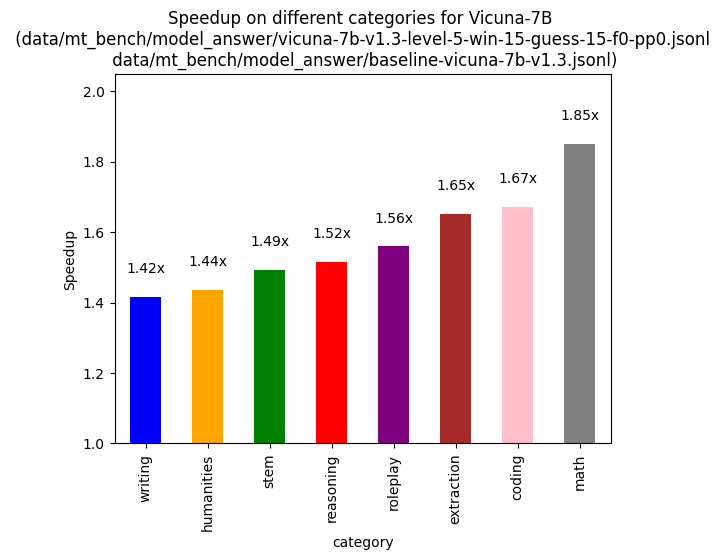

In [20]:
import matplotlib.pyplot as plt

speed_up.plot.bar(bottom = 0, color=['blue','orange','green','red','purple','brown','pink','grey'])
for i, value in enumerate(speed_up):     
    plt.text(i, value+0.1, str('%.2fx'%value), ha='center', va='top')
plt.ylim((1.0, speed_up.max()+0.2))
plt.xlabel('category')
plt.ylabel('Speedup')
plt.title(f'Speedup on different categories for Vicuna-7B \n ({medusa_path} \n {base_path})')
plt.show()